In [1]:
 # Load libraries
import pandas as pd
import numpy as np
import scipy.io as sp
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
############## Loading data for the two hot wires ###########

mat_contents = sp.loadmat('data/data.mat')
mat = mat_contents['data']
hw1 = pd.DataFrame({'WS': mat[:,15]})
hw2 = pd.DataFrame({'WS': mat[:,16]})


In [3]:
################################################################
################## Convert indices to datetime#################
################## 5000Hz sampling ##############################
index = pd.date_range('1/1/2020', periods=len(hw1['WS']), freq='0.2ms')
hw1.index = index
hw2.index = index


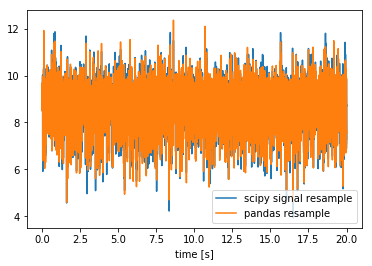

         WS
0  9.184082
1  9.564550
2  9.670743
3  9.682283
4  9.628029
            WS
9995  9.857430
9996  9.270512
9997  8.678705
9998  8.761600
9999  6.901293


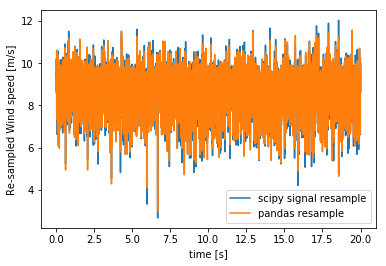

          WS
0   9.361128
1   9.593526
2   9.822517
3   9.877486
4  10.136771
            WS
9995  9.499470
9996  8.764392
9997  8.623932
9998  8.830188
9999  9.973775


In [4]:
###################### Resample dataset for training and validation ########
###################### Data is downsampled to 500 Hz
from scipy import signal
res_freq = int(len(hw1['WS'])/10) 
hw1_resampled1 = pd.DataFrame({'WS': signal.resample(hw1['WS'], res_freq)})
hw2_resampled1 = pd.DataFrame({'WS': signal.resample(hw2['WS'], res_freq)})


hw1_resampled2 = hw1.resample('0.002 S').mean()
hw2_resampled2 = hw2.resample('0.002 S').mean()

hw1_resampled1 = hw1_resampled1[0:10000]
hw2_resampled1 = hw2_resampled1[0:10000]

hw1_resampled2 = hw1_resampled2[0:10000]
hw2_resampled2 = hw2_resampled2[0:10000]


t = pd.DataFrame({'time' : np.linspace(0,len(hw1_resampled1)/500,len(hw1_resampled1))})
plt.plot(t, hw1_resampled1['WS'].values, label='scipy signal resample')
plt.plot(t, hw1_resampled2['WS'].values, label='pandas resample')
plt.xlabel('time [s]')
plt.legend()
plt.show()

hw1_resampled = hw1_resampled1
hw2_resampled = hw2_resampled1
print(hw1_resampled.head())
print(hw1_resampled.tail())

plt.plot(t, hw2_resampled1['WS'].values, label='scipy signal resample')
plt.plot(t, hw2_resampled2['WS'].values, label='pandas resample')
plt.ylabel('Re-sampled Wind speed [m/s]')
plt.xlabel('time [s]')
plt.legend()
plt.show()

print(hw2_resampled.head())
print(hw2_resampled.tail())


In [ ]:
# ########## Turbulence intensity #########
# stdhw1 = hw1_resampled['WS'].std()
# stdhw2 = hw2_resampled['WS'].std()
# TIhw1 = stdhw1/hw1_resampled['WS']*100
# TIhw2 = stdhw1/hw2_resampled['WS']*100

# f,ax = plt.subplots(ncols=1, nrows=1)
# ax.plot(t, hw1_resampled['WS'],'k', label='Wind Speed [m/s]')
# ax.plot(t, TIhw1,'-',label = 'TI [%]')
# plt.xlabel('Time [s]')
# plt.legend()
# ax.grid(b=True, which='major', color='silver', linestyle='-')
# plt.show()

# f,ax = plt.subplots(ncols=1, nrows=1)
# ax.plot(t, hw2_resampled['WS'],'k', label='Wind Speed [m/s]')
# ax.plot(t, TIhw2,'-',label = 'TI [%]')
# plt.xlabel('Time [s]')
# plt.legend()
# ax.grid(b=True, which='major', color='silver', linestyle='-')
# plt.show()

In [5]:
####################################################################
################ Prepare dataset for LSTM problem ##################
####################################################################

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib


### define a function that will split the sequences to input and output of the training
def series_to_forecast(data, n_in, n_out, dropnan=True):
    """
    A function that will split the time series to input and output for training 
    of the forecast problem with supervised learning
    Arguments:
        data: Sequence of observations as a list, NumPy array or pandas series
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.shape[1] # antal kolonner
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) # df.shift skifter index. append slår vist data sammen.
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)] # += adderer og definerer på een gang. 
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### bring the functions together for compact prepare data function
def prepare_data(scaled_values, n_lag, n_seq):
    """
    A function that combines differencing and scaling. Prepares the data for robust LSTM training.
    Arguments:
        series: time series to be prepared for training
        n_lag: number of previous hourly time steps to use for training
        n_seq: forecast horizon [h] 
    Returns:
        Pandas DataFrame of quasi-stationary time series framed for supervised learning.
    """
    # transform into supervised learning problem X, y
    supervised = series_to_forecast(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    return supervised_values


### Split data into train & test 
train_int = np.int(0.8*len(hw1_resampled['WS']))

### training input vector
hw1_train_in = hw1_resampled['WS'][1:train_int]
hw2_train_in = hw2_resampled['WS'][1:train_int]

X_train =  pd.DataFrame(hw1_train_in)
Y_train = pd.DataFrame(hw2_train_in)

### test input vector
hw1_test_in = hw1_resampled['WS'][train_int:]
hw2_test_in = hw2_resampled['WS'][train_int:]

X_validation = pd.DataFrame(hw1_test_in)
Y_validation = pd.DataFrame(hw2_test_in) 



n_in = 29 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 1  # forecast horizon [s] 

### scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_scaler = scaler
X_scaler_filename = 'X_scaler_org.save'
joblib.dump(X_scaler, X_scaler_filename)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_validation_scaled = scaler.transform(Y_validation)
Y_scaler = scaler
Y_scaler_filename = 'Y_scaler_org.save'
joblib.dump(Y_scaler, Y_scaler_filename)

### frame dataset for LSTM with lags
X_train_framed = prepare_data(X_train_scaled, n_in, n_out)
X_validation_framed = prepare_data(X_validation_scaled, n_in, n_out)
Y_train_framed =  Y_train_scaled[n_in:]
Y_validation_framed = Y_validation_scaled[n_in:]


print('Training input (samples, timesteps):', X_train_framed.shape)
print('Training output (samples, timesteps):', Y_train_framed.shape)
print('Validation input (samples, timesteps):', X_validation_framed.shape)
print('Validation output (samples, timesteps):', Y_validation_framed.shape)





Training input (samples, timesteps): (7970, 30)
Training output (samples, timesteps): (7970, 1)
Validation input (samples, timesteps): (1971, 30)
Validation output (samples, timesteps): (1971, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                22560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 143,801
Trainable params: 143,801
Non-trainable params: 0
_________________________________________________________________
Trai

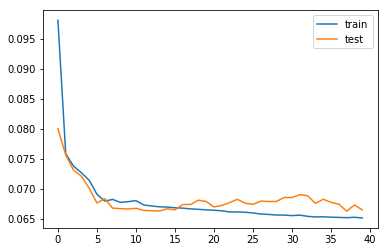

Wall time: 12min 17s


In [6]:
###################### Training

%%time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.regularizers import l1_l2 as L1L2
from keras.utils import plot_model 
from keras.callbacks import TensorBoard
import keras.backend as K


# reshape input to be 3D [samples, timesteps, features] -- expected by LSTM
train_X = X_train_framed.reshape((X_train_framed.shape[0], n_in+1, 1))
test_X = X_validation_framed.reshape((X_validation_framed.shape[0], n_in+1, 1))
train_y = (Y_train_framed)
test_y = (Y_validation_framed)

# Tensorboard graph
tbGraph = TensorBoard(log_dir=f'./TensorBoard_Graphs/Case2',
                      histogram_freq=64*2, write_graph=True, write_images=True, write_grads=True)
# for multiple model creation - clear  the previous DAG
K.clear_session() 

##### Designing network #######
n_batch = 60 
epo_num = 40 
model = Sequential()
### 100-neurons in first the hidden layer
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
### Add the first activation layer - no need for tanh (default activation in Keras LSTM layers), mainly for illustration purposes
model.add(Activation('tanh'))
### Add another hidden layer
model.add(LSTM(100, return_sequences=True))
model.add(Activation('tanh'))
### Add another hidden layer
model.add(LSTM(40))
### 1-neuron in the output layer - due to single output
model.add(Dense(1))
### mean-absolute-error (MAE) loss function & Adam version of stochastic gradient descent
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()
plot_model(model, to_file='model_Case2.png')
    
### fit network 
history = model.fit(train_X, train_y,
                    epochs = epo_num, 
                    batch_size=n_batch, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False,
                    callbacks=[tbGraph])
### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

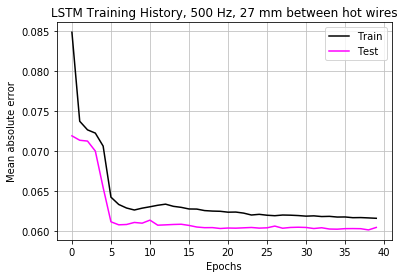

In [9]:
### plot model & history
plot_model(model, to_file='model_Case2_simpler.pdf')
f,ax = plt.subplots(ncols=1, nrows=1)
ax.plot(history.history['loss'], 'k',label='Train')
ax.plot(history.history['val_loss'], 'magenta', label='Test')
plt.title('LSTM Training History, 500 Hz, 27 mm between hot wires')
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.legend()
ax.grid(b=True, which='major', color='silver', linestyle='-')
plt.show()

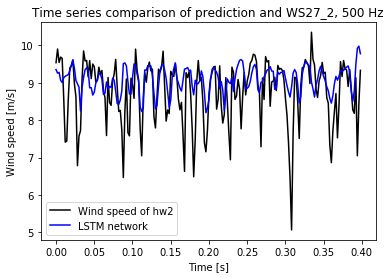

In [7]:
# ####### make a prediction ##########
############### Only the first 0.4 out of the 2s predicted is plotted.
############### If a longer signal is plotted the fluctiations are unclear
yhat_l = list()
y_l = list()

yhat = model.predict(test_X, batch_size=n_batch)
### invert scaling for prediction
inv_yhat = scaler.inverse_transform(yhat)
### invert scaling for actual
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,0]
yhat_l.extend(inv_yhat)
y_l.extend(inv_y) 
### Simple plot
y_ar = np.asarray(y_l)
yhat_ar = np.asarray(yhat_l)
t2 = pd.DataFrame({'time' : np.linspace(0,len(y_ar)/500,len(y_ar))})
plt.plot(t2[0:200], y_ar[0:200], 'k', label='Wind speed of hw2')
plt.plot(t2[0:200], yhat_ar[0:200],'b',label='LSTM network')
plt.xlabel('Time [s]')
plt.ylabel('Wind speed [m/s]')
plt.legend()
plt.title('Time series comparison of prediction and WS27_2, 500 Hz')
plt.show()